In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

from collab2.foraging.toolkit import (
    animate_predictors,
    constraint_filter_nearest,
    dataObject,
    generate_local_windows,
    plot_predictor,
    rescale_to_grid,
    subsample_frames_constant_frame_rate,
)
from collab2.foraging.toolkit.point_contribution import _point_contribution
from collab2.foraging.toolkit.proximity import (
    _generate_proximity_predictor,
    _piecewise_proximity_function,
    generate_proximity_predictor,
)

In [2]:
# create a test object with random data
num_frames = 8
num_foragers = 4
grid_size = 30
n_nans = int(num_frames * num_foragers / 5)
n_missing = int(num_frames * num_foragers / 5)
gridMin = -1
gridMax = 1

np.random.seed(42)

# generate data in a unit disk
theta = 2 * np.pi * np.random.rand(num_frames * num_foragers)
r = np.random.rand(num_frames * num_foragers)

data = {
    "x": r * np.cos(theta),
    "y": r * np.sin(theta),
    "time": np.tile(np.arange(num_frames), num_foragers),
    "forager": np.concatenate([i * np.ones(num_frames) for i in range(num_foragers)]),
}

foragersDF = pd.DataFrame(data)

foragersDF_scaled = rescale_to_grid(
    foragersDF, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
foragers_object = dataObject(foragersDF_scaled, grid_size=grid_size)

In [3]:
# get local windows
local_windows_kwargs = {
    "window_size": 10,
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows = generate_local_windows(foragers_object)

0.3090169943749474


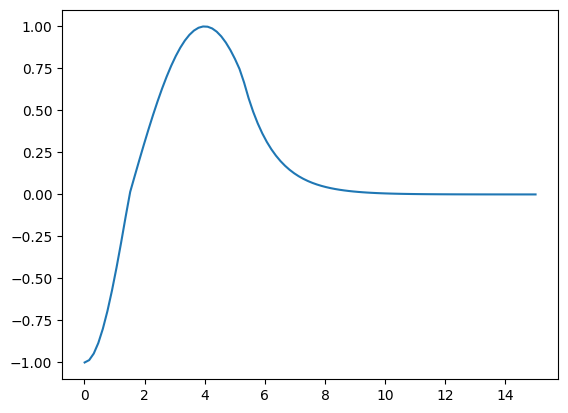

In [4]:
print(_piecewise_proximity_function(2))

distance = np.linspace(0.01, 15, 100)

proximity = _piecewise_proximity_function(distance)

plt.plot(distance, proximity)
plt.show()

In [5]:
distance_lj = np.linspace(4.01, 40, 100)

s = 3
n = 4
m = 2


def negative_lj(r, s_n, s_m, n, m):
    return -((s / (r + 10e-6)) ** n) + (s / (r + 10e-6)) ** m


# plt.plot(distance_lj, [negative_lj(d, s_n, s_m, n, m) for d in distance])
# # add vertical line at optimal distance
# plt.axvline(x=7.7, color="red", linestyle="--")
# plt.axvline(x=7.22, color="red", linestyle="--")
# plt.axvline(x=7.22 - (7.7-7.22), color="red", linestyle="--")
# #add horizontal line at 0
# plt.axhline(y=0, color="black", linestyle="--")

# plt.ylim(-3, 1)

# #plt.xlim(6,9)
# plt.show()

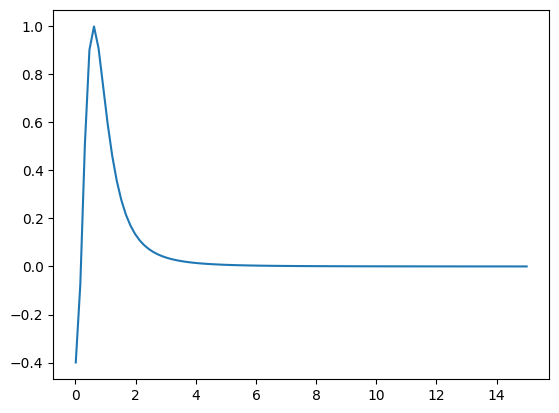

In [6]:
def softcore_potential(r, epsilon=1.0, sigma=1.0):
    return -epsilon * (1 / ((r**2 + sigma**2) ** 6) - 2 / ((r**2 + sigma**2) ** 3))


def softcore_potential(r, epsilon=1.0, sigma=1.0, power=3):
    return -epsilon * (
        1 / ((r**2 + sigma**2) ** power) - 2 / ((r**2 + sigma**2) ** (power / 2))
    )


plt.plot(
    distance, [softcore_potential(d, epsilon=1, sigma=0.8, power=3.5) for d in distance]
)

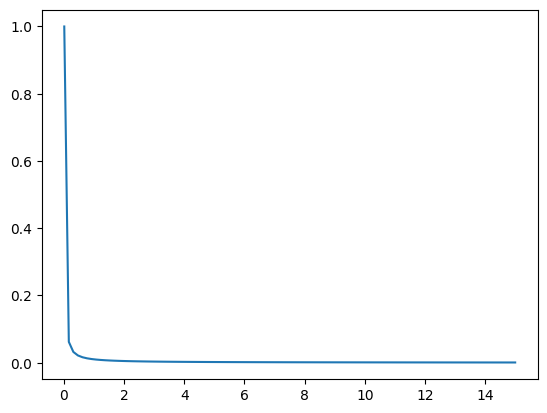

In [7]:
# yukawa coulomb potential


def yukawa_potential(r, epsilon=1.0, sigma=1.0):
    return epsilon * np.exp(-r / sigma) / r


plt.plot(distance, [yukawa_potential(d, epsilon=0.01, sigma=10e7) for d in distance])

In [8]:
# proximity_predictor_contribution for a test case
test_pred = [[None for i in range(num_frames)] for j in range(num_foragers)]

# compute the predictor contribution for a random case
f = 3
t = 3
x = foragers_object.foragers[f].loc[t, "x"]
y = foragers_object.foragers[f].loc[t, "y"]

In [9]:
proximity_1 = _point_contribution(
    x_source=16,
    y_source=13,
    grid=local_windows[f][t],
    contribution_function=_piecewise_proximity_function,
    repulsion_radius=1.5,
    optimal_distance=4,
    proximity_decay=1,
)

proximity_2 = _point_contribution(
    x_source=8,
    y_source=7,
    grid=local_windows[f][t],
    contribution_function=_piecewise_proximity_function,
    repulsion_radius=1.5,
    optimal_distance=4,
    proximity_decay=1,
)

# additive combination
test_pred[f][t] = local_windows[f][t].copy()
test_pred[f][t]["proximity"] = proximity_1 + proximity_2

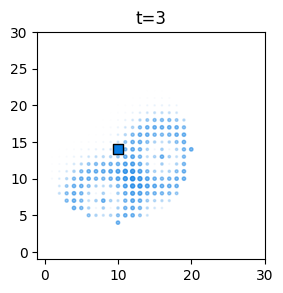

In [10]:
plot_predictor(
    foragers_object.foragers,
    test_pred,
    "proximity",
    [f],
    [t],
    grid_size,
    size_multiplier=10,
    random_state=10,
)

In [12]:
# load data
fish_data = pd.read_csv("4wpf_test.csv")
gridMin = 0
gridMax = 300
grid_size = 50
fps = 121

# scaling and subsampling
fishDF_scaled = rescale_to_grid(
    fish_data, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
fishDF_scaled_subsampled = subsample_frames_constant_frame_rate(
    fishDF_scaled, frame_spacing=60
)

# create a test foragers object with 20 frames
num_frames = 20
foragers_object = dataObject(
    fishDF_scaled_subsampled.loc[fishDF_scaled_subsampled["time"] < 20],
    grid_size=grid_size,
)

# get local windows
local_windows_kwargs = {
    "window_size": grid_size / 2,
    "sampling_fraction": 1,
    "skip_incomplete_frames": True,
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows = generate_local_windows(foragers_object)

ppr = _generate_proximity_predictor(
    foragers_object.foragers,
    foragers_object.foragersDF,
    local_windows,
    predictor_name="pred",
    interaction_length=grid_size / 3,
    interaction_constraint=None,
    interaction_constraint_params=None,
    proximity_function=_piecewise_proximity_function,
    repulsion_radius=1.5,
    optimal_distance=4,
    proximity_decay=1,
)

# ppr[0][0]["pred"] take non-zero

ppr_non_null = ppr[0][0]["pred"][ppr[0][0]["pred"] > 0.01]

plt.hist(ppr[0][0]["pred"], bins=50)
plt.title(f"Sum of those is {ppr[0][0]['pred'].abs().sum()}")
plt.show()

plt.hist(ppr_non_null, bins=50)
plt.title(f"Sum of those is {ppr_non_null.abs().sum()}")
plt.show()


plot_predictor(
    foragers_object.foragers,
    ppr,
    "pred",
    [1],
    range(num_frames),
    grid_size,
    size_multiplier=10,
    random_state=99,
)

original_frames: 18739
original_shape: (74956, 5)
resulting_frames: 313
resulting_shape: (1252, 5)


/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:42: UserWarning: 
                NaN values in data. The default behavior of predictor/score generating functions is
                to ignore foragers with missing positional data. To modify, see documentation of
                `derive_predictors_and_scores` and `generate_local_windows`
                
  warnings.warn(


TypeError: filter_by_distance() takes from 4 to 5 positional arguments but 6 were given

In [ ]:
# adding interaction constraint: nearest neighbor


def constraint_filter_nearest(f_ind, f, t, foragersDF, params):
    current_positions = foragersDF.loc[
        np.logical_and(foragersDF["forager"].isin(f_ind), foragersDF["time"] == t)
    ]

    x_f = foragersDF.loc[
        np.logical_and(foragersDF["forager"] == f, foragersDF["time"] == t), "x"
    ].values[0]

    y_f = foragersDF.loc[
        np.logical_and(foragersDF["forager"] == f, foragersDF["time"] == t), "y"
    ].values[0]

    distances = np.sqrt(
        (current_positions["x"] - x_f) ** 2 + (current_positions["y"] - y_f) ** 2
    )

    return current_positions["forager"][distances == distances.min()].to_list()

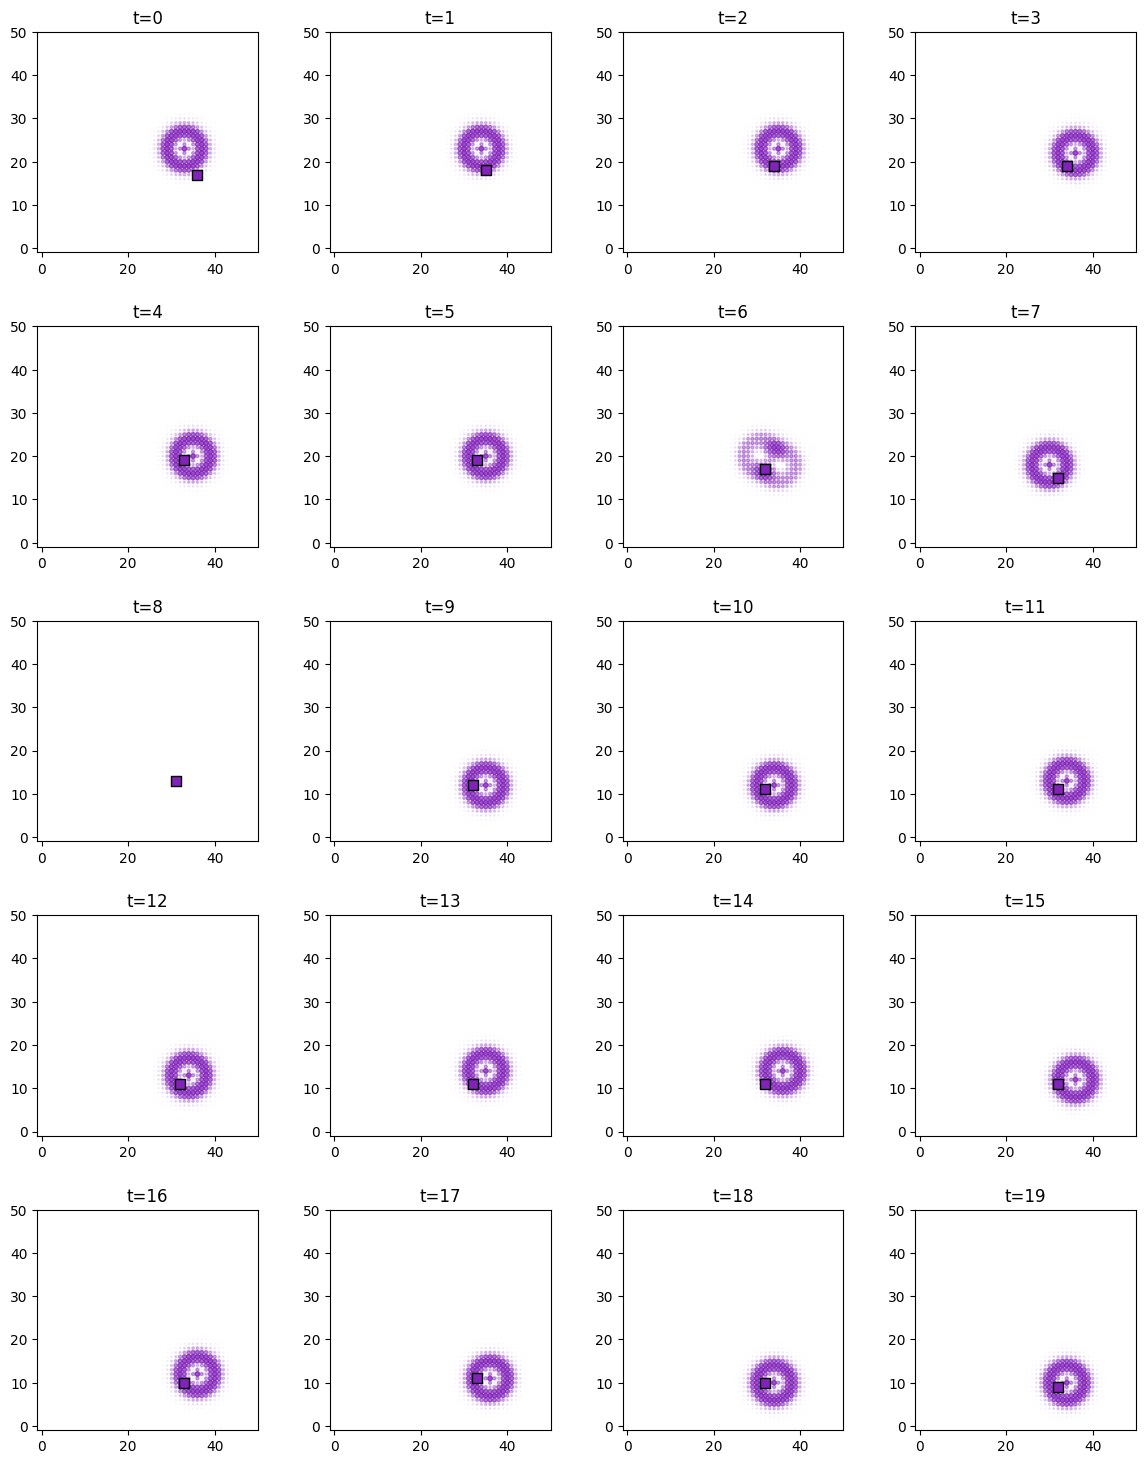

In [ ]:
pred_max = _generate_proximity_predictor(
    foragers_object.foragers,
    foragers_object.foragersDF,
    local_windows,
    predictor_name="pred",
    interaction_length=grid_size / 3,
    interaction_constraint=constraint_filter_nearest,
    interaction_constraint_params={"f_ind": [0, 1, 2, 3]},
    proximity_function=_piecewise_proximity_function,
    repulsion_radius=1.5,
    optimal_distance=4,
    proximity_decay=1,
)

plot_predictor(
    foragers_object.foragers,
    pred_max,
    "pred",
    [0],
    range(num_frames),
    grid_size,
    size_multiplier=10,
    random_state=99,
)

In [13]:
# load data
fish_data = pd.read_csv("4wpf_test.csv")
gridMin = 0
gridMax = 300
grid_size = 50
fps = 121

# scaling and subsampling
fishDF_scaled = rescale_to_grid(
    fish_data, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
fishDF_scaled_subsampled = subsample_frames_constant_frame_rate(
    fishDF_scaled, frame_spacing=60
)

# create a test foragers object with 20 frames
num_frames = 20
foragers_object = dataObject(
    fishDF_scaled_subsampled.loc[fishDF_scaled_subsampled["time"] < 20],
    grid_size=grid_size,
)

# generate local windows and add to object
local_windows_kwargs = {
    "window_size": grid_size / 2,
    "sampling_fraction": 1,
    "skip_incomplete_frames": True,
}
foragers_object.local_windows_kwargs = local_windows_kwargs
local_windows = generate_local_windows(foragers_object)
foragers_object.local_windows = local_windows

predictor_kwargs = {
    "pred": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": None,
        "proximity_function": _piecewise_proximity_function,
        "repulsion_radius": 1.5,
        "optimal_distance": 4,
        "proximity_decay": 1,
    }
}


foragers_object.predictor_kwargs = predictor_kwargs

proximity = generate_proximity_predictor(foragers_object, "pred")


ani = animate_predictors(
    foragers_object.foragersDF,
    proximity,
    predictorID="pred",
    forager_index=[0, 3],
    grid_size=grid_size,
    random_state=10,
    size_multiplier=10,
)
HTML(ani.to_jshtml())

original_frames: 18739
original_shape: (74956, 5)
resulting_frames: 313
resulting_shape: (1252, 5)


/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:42: UserWarning: 
                NaN values in data. The default behavior of predictor/score generating functions is
                to ignore foragers with missing positional data. To modify, see documentation of
                `derive_predictors_and_scores` and `generate_local_windows`
                
  warnings.warn(


TypeError: filter_by_distance() takes from 4 to 5 positional arguments but 6 were given